In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform
from scipy.ndimage import gaussian_filter, maximum_filter

In [5]:
def rgb_to_gray(image):
    return color.rgb2gray(image)

def generate_scale_space(image, num_octaves=4, num_scales=5, sigma=1.6):
    octaves = []
    k = 2 ** (1 / num_scales)
    for _ in range(num_octaves):
        octave = [gaussian_filter(image, sigma * (k ** i)) for i in range(num_scales)]
        octaves.append(octave)
        image = transform.rescale(image, 0.5, anti_aliasing=False)
    return octaves

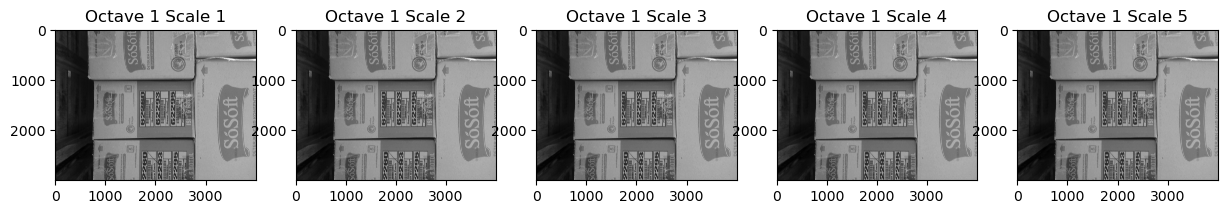

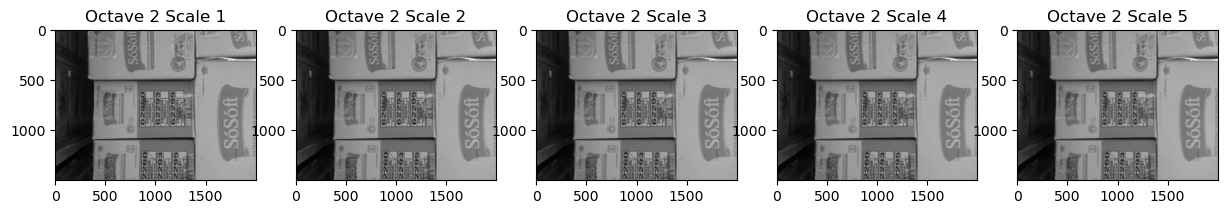

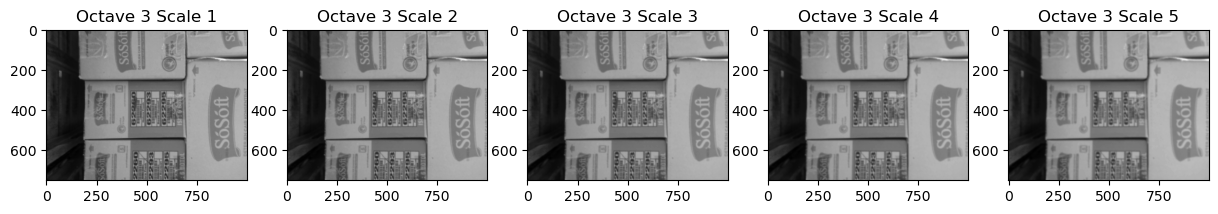

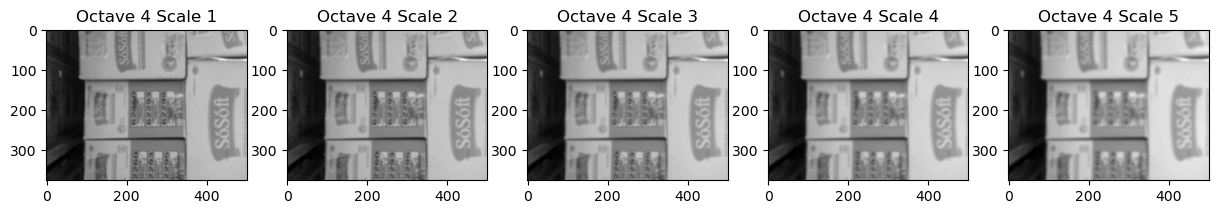

In [6]:
image = io.imread('test1.jpg')
gray_image = rgb_to_gray(image)
octaves = generate_scale_space(gray_image)
for i, octave in enumerate(octaves):
    plt.figure(figsize=(15, 10))
    for j, img in enumerate(octave):
        plt.subplot(1, len(octave), j + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Octave {i+1} Scale {j+1}")
    plt.show()

In [7]:
def compute_dog(octaves):
    dog = []
    for octave in octaves:
        dog_octave = [octave[i] - octave[i + 1] for i in range(len(octave) - 1)]
        dog.append(dog_octave)
    return dog

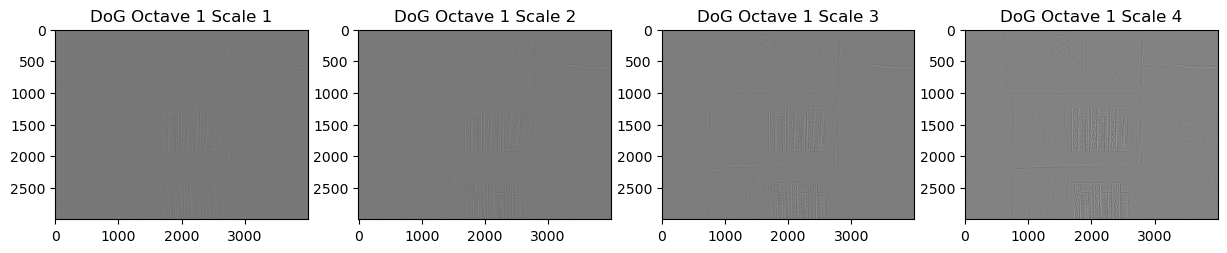

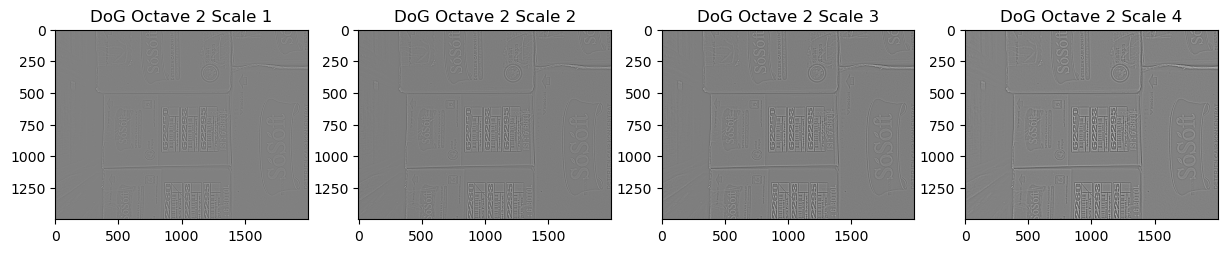

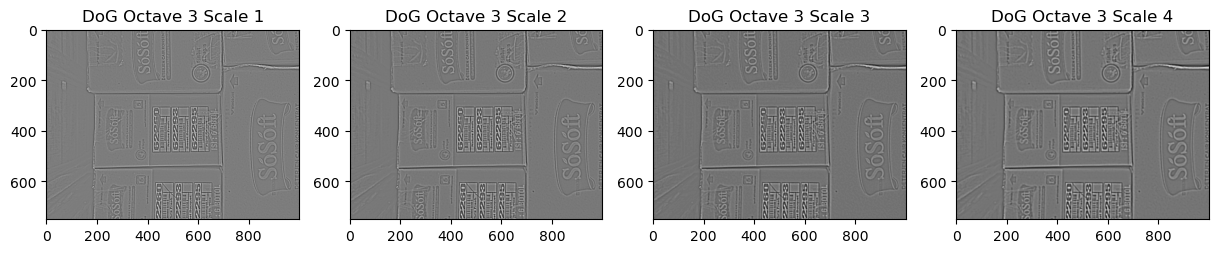

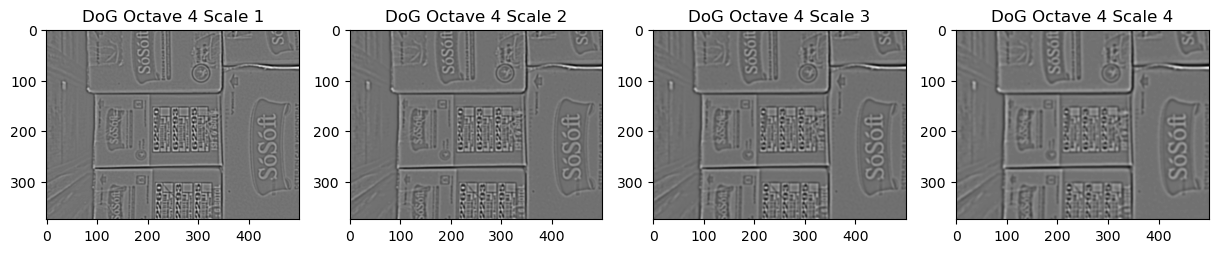

In [8]:
dog_images = compute_dog(octaves)
for i, dog_octave in enumerate(dog_images):
    plt.figure(figsize=(15, 10))
    for j, img in enumerate(dog_octave):
        plt.subplot(1, len(dog_octave), j + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"DoG Octave {i+1} Scale {j+1}")
    plt.show()

In [10]:
def detect_keypoints(dog, threshold=0.04):
    keypoints = []
    for o, dog_octave in enumerate(dog):
        for s, dog_image in enumerate(dog_octave[1:-1], 1):
            max_filt = maximum_filter(dog_image, size=3)
            min_filt = -maximum_filter(-dog_image, size=3)
            kp = np.argwhere((dog_image == max_filt) & (dog_image > threshold) |
                             (dog_image == min_filt) & (dog_image < -threshold))
            keypoints.append((o, s, kp))
    return keypoints

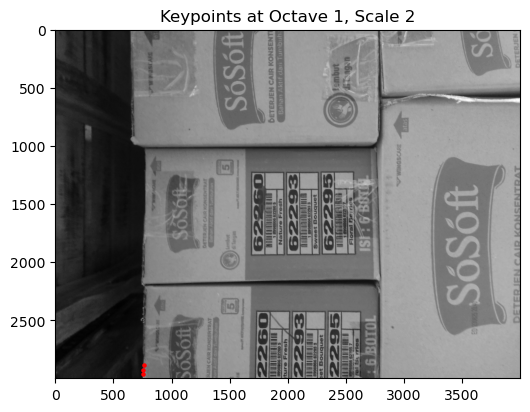

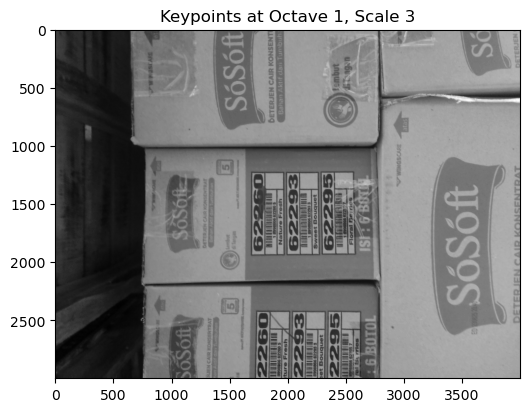

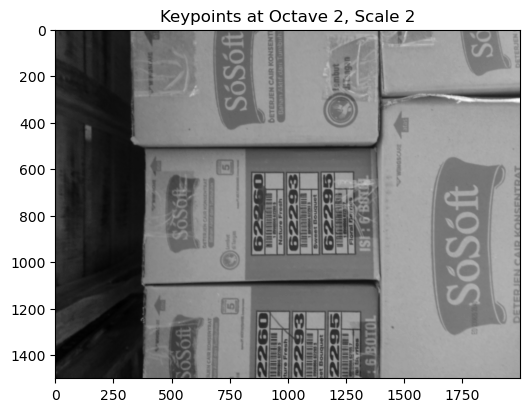

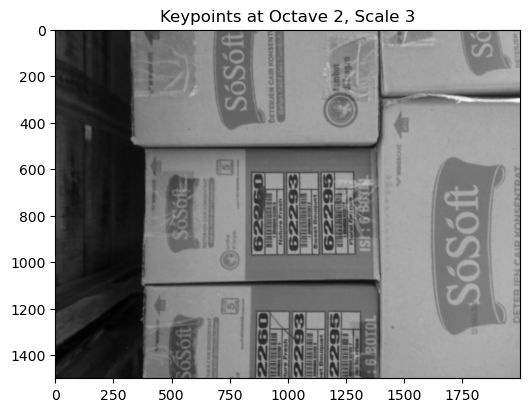

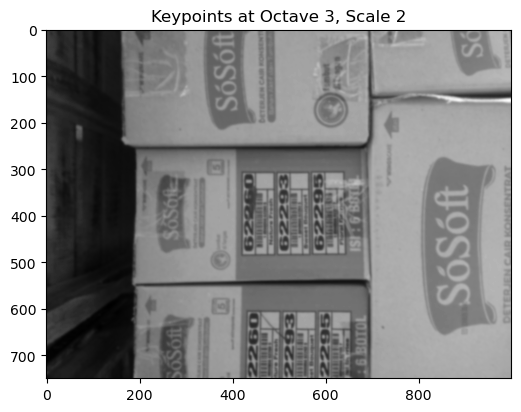

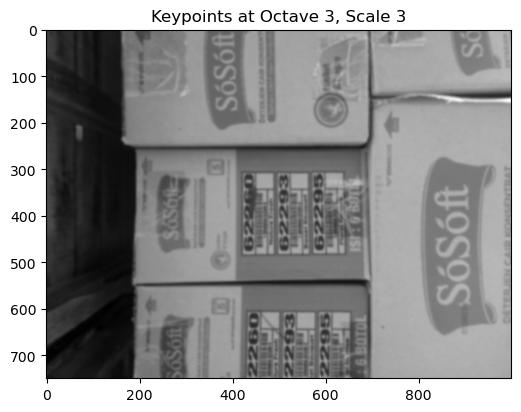

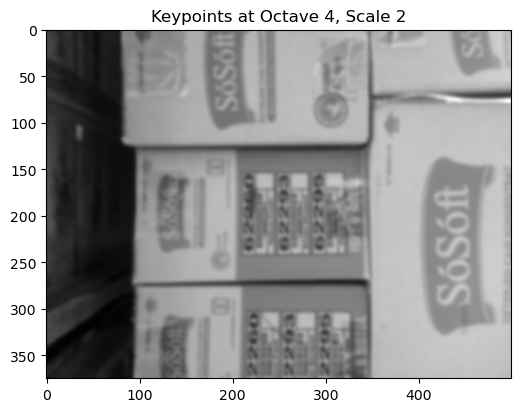

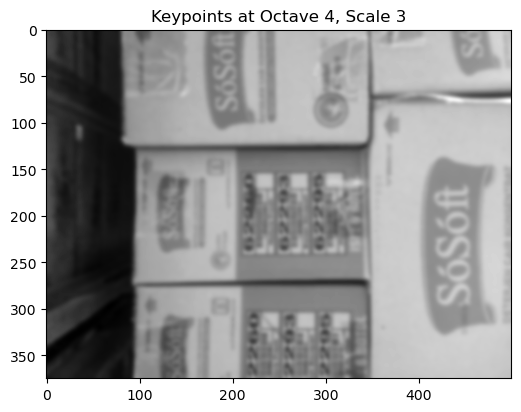

In [11]:
keypoints = detect_keypoints(dog_images)

# Plot keypoints on the original image
for i, (o, s, kp) in enumerate(keypoints):
    plt.figure(figsize=(6, 6))
    plt.imshow(octaves[o][s], cmap='gray')
    plt.scatter(kp[:, 1], kp[:, 0], c='r', s=5)
    plt.title(f"Keypoints at Octave {o+1}, Scale {s+1}")
    plt.show()


In [12]:
def compute_gradient(image):
    dy, dx = np.gradient(image)
    magnitude = np.sqrt(dx**2 + dy**2)
    orientation = np.arctan2(dy, dx)
    return magnitude, orientation

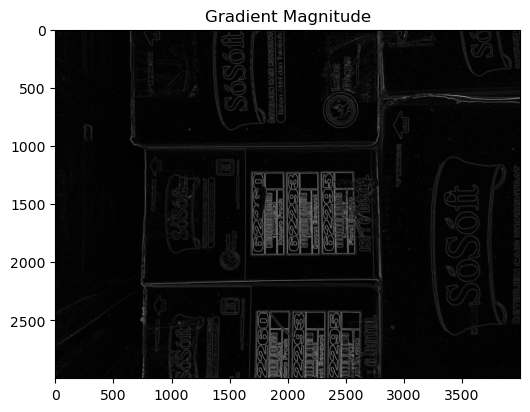

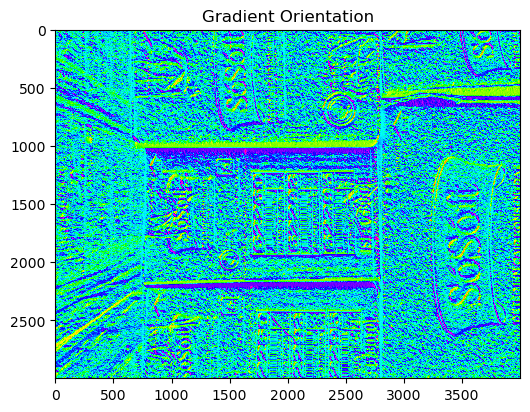

In [13]:
o, s, kp = keypoints[0]  # Example keypoints from the first octave and second scale
magnitude, orientation = compute_gradient(octaves[o][s])

plt.figure(figsize=(6, 6))
plt.imshow(magnitude, cmap='gray')
plt.title("Gradient Magnitude")
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(orientation, cmap='hsv')
plt.title("Gradient Orientation")
plt.show()

In [15]:
def extract_features(keypoints, octaves, num_bins=36):
    features = []
    for (o, s, keypts) in keypoints:
        for y, x in keypts:
            magnitude, orientation = compute_gradient(octaves[o][s])
            # Create a histogram of gradient orientations
            hist, _ = np.histogram(orientation[y-8:y+8, x-8:x+8], bins=num_bins, weights=magnitude[y-8:y+8, x-8:x+8])
            features.append(hist)
    return np.array(features)

In [16]:
features = extract_features(keypoints, octaves)
print("Feature vector for the first keypoint:", features[0])

Feature vector for the first keypoint: [1.21902210e-01 3.28939408e-02 0.00000000e+00 2.96271736e-02
 0.00000000e+00 2.01025145e-02 0.00000000e+00 0.00000000e+00
 1.46898321e-03 0.00000000e+00 1.14582214e-02 0.00000000e+00
 2.38639006e-03 7.31000218e-02 7.27464145e-02 1.52417207e-01
 9.72718624e-01 2.07672776e+00 1.79820491e+00 7.32091107e-01
 2.78557406e-01 2.30657614e-01 1.09794706e-01 1.61895622e-02
 7.64859061e-02 1.30757196e-01 5.78191758e-02 1.13913368e-02
 1.28728198e-02 6.66030371e-02 7.49144255e-02 1.34736800e-01
 1.49672832e-01 7.94379040e-02 1.51393995e-01 1.78696981e-01]


In [17]:
def sift(image_path):
    image = rgb_to_gray(io.imread(image_path))
    octaves = generate_scale_space(image)
    dog = compute_dog(octaves)
    keypoints = detect_keypoints(dog)
    features = extract_features(keypoints, octaves)
    return keypoints, features

image_path = 'test1.jpg'
keypoints, features = sift(image_path)

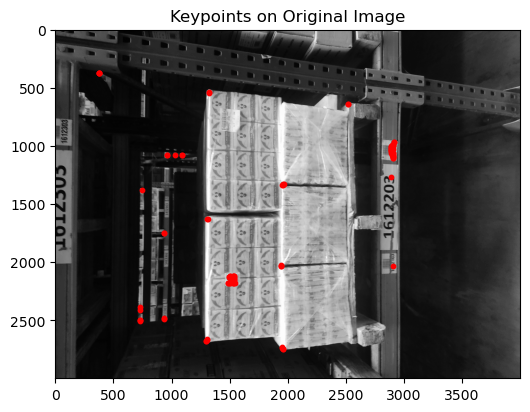

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform
from scipy.ndimage import gaussian_filter, maximum_filter

# Step 1: Convert the image to grayscale
def rgb_to_gray(image):
    return color.rgb2gray(image)

# Step 2: Generate scale-space
def generate_scale_space(image, num_octaves=4, num_scales=5, sigma=1.6):
    octaves = []
    k = 2 ** (1 / num_scales)
    for _ in range(num_octaves):
        octave = [gaussian_filter(image, sigma * (k ** i)) for i in range(num_scales)]
        octaves.append(octave)
        image = transform.rescale(image, 0.5, anti_aliasing=False)
    return octaves

# Step 3: Compute Difference of Gaussian (DoG)
def compute_dog(octaves):
    dog = []
    for octave in octaves:
        dog_octave = [octave[i] - octave[i + 1] for i in range(len(octave) - 1)]
        dog.append(dog_octave)
    return dog

# Step 4: Detect keypoints
def detect_keypoints(dog, threshold=0.04):
    keypoints = []
    for o, dog_octave in enumerate(dog):
        for s, dog_image in enumerate(dog_octave[1:-1], 1):
            max_filt = maximum_filter(dog_image, size=3)
            min_filt = -maximum_filter(-dog_image, size=3)
            kp = np.argwhere((dog_image == max_filt) & (dog_image > threshold) |
                             (dog_image == min_filt) & (dog_image < -threshold))
            keypoints.append((o, s, kp))
    return keypoints

# Step 5: Visualize keypoints
def visualize_keypoints(image, keypoints, octaves):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    
    for o, s, kp in keypoints:
        plt.scatter(kp[:, 1] * (2 ** o), kp[:, 0] * (2 ** o), c='r', s=10)
    
    plt.title("Keypoints on Original Image")
    plt.show()

# Run the SIFT process and visualize the keypoints
image_path = 'test2.jpg'
image = io.imread(image_path)
gray_image = rgb_to_gray(image)
octaves = generate_scale_space(gray_image)
dog_images = compute_dog(octaves)
keypoints = detect_keypoints(dog_images)

# Visualize keypoints on the original image
visualize_keypoints(gray_image, keypoints, octaves)


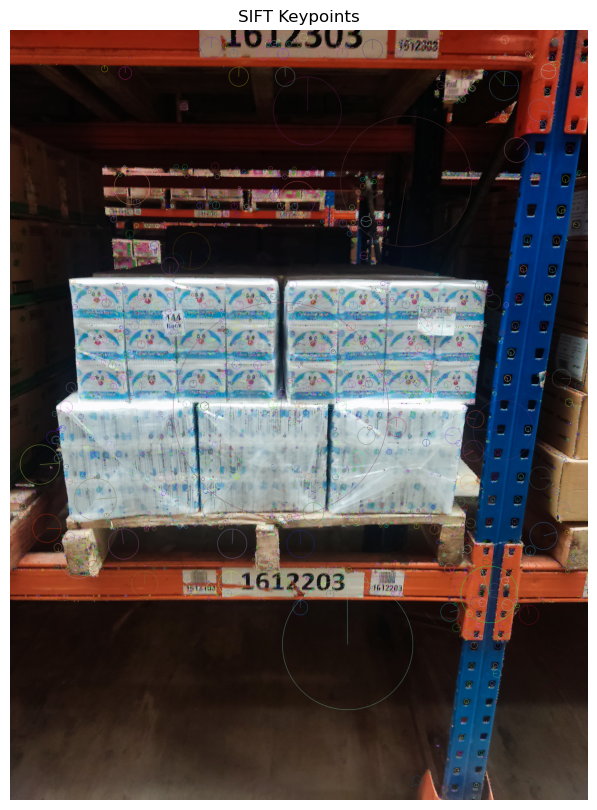

In [20]:
import cv2
import matplotlib.pyplot as plt

# Step 1: Load the image
image_path = 'test2.jpg'
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Initialize the SIFT detector
sift = cv2.SIFT_create()

# Step 3: Detect SIFT keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(gray_image, None)

# Step 4: Visualize the keypoints
keypoints_image = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Convert the image from BGR to RGB (for displaying with matplotlib)
keypoints_image_rgb = cv2.cvtColor(keypoints_image, cv2.COLOR_BGR2RGB)

# Step 5: Display the image with keypoints
plt.figure(figsize=(10, 10))
plt.imshow(keypoints_image_rgb)
plt.title("SIFT Keypoints")
plt.axis('off')
plt.show()


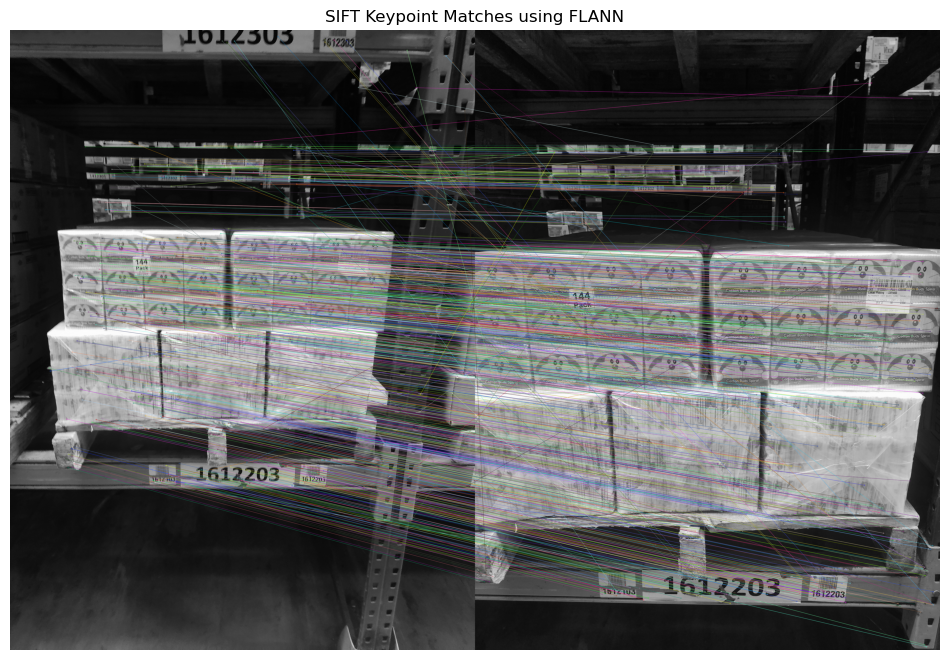

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
image1_path = 'test2.jpg'  # Replace with your image path
image2_path = 'test3.jpg'  # Replace with your image path

image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # Higher checks lead to more accurate results but are slower

# Initialize the FLANN based matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match descriptors using KNN
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Apply the ratio test to select good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Draw the matches
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Convert the image to RGB (for displaying with matplotlib)
matched_image_rgb = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)

# Display the matched image
plt.figure(figsize=(12, 12))
plt.imshow(matched_image_rgb)
plt.title("SIFT Keypoint Matches using FLANN")
plt.axis('off')
plt.show()

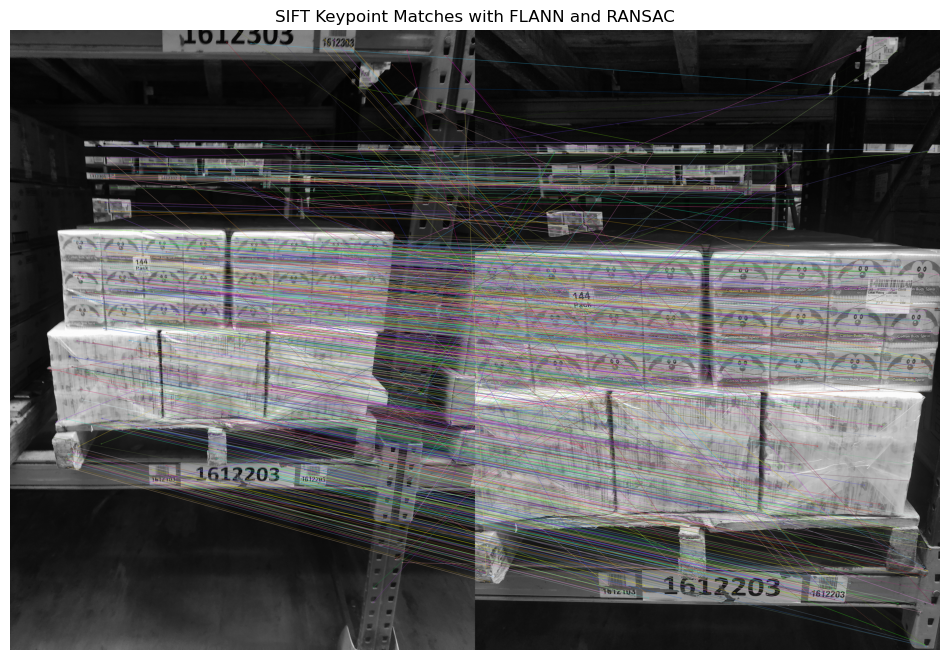

Raw distances: [164.21327209 249.46542358 109.89085388 152.5483551  122.29472351
 166.95507812  95.93747711 139.80343628 138.27870178  99.82985687
 200.19241333 155.99038696 200.13494873 149.68968201  76.36753082
 121.69223785 135.0740509  127.00787354 103.53742981 164.93331909
  71.40028381 126.05554199 142.49211121  93.42376709 109.91360474
  50.59644318  78.72737885  73.21884918 105.86784363 104.64702606
  84.60496521 184.06248474 114.73447418  65.66581726 166.58030701
 111.4719696  123.53137207 140.09996033 129.34837341 184.24983215
 132.72904968 146.44111633 117.38398743 122.68251801  87.43569183
  73.60027313  56.63037872  86.98275757 107.58717346  77.53063965
 131.64726257  78.17928314 157.60076904  72.53964233 131.77253723
 145.0965271  114.56002808  74.45132446 144.19778442 137.56816101
 150.38949585 198.11360168 124.73571777 117.01281738 180.06109619
 148.5025177  100.96038818 109.98636627 108.71062469 103.46497345
 142.34114075 127.22814178 134.02238464 122.18019104 224.6975

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def normalize_distances(distances):
    min_distance = np.min(distances)
    max_distance = np.max(distances)
    if max_distance == min_distance:  # Avoid division by zero
        return np.zeros_like(distances)
    normalized = (distances - min_distance) / (max_distance - min_distance)
    return normalized

def are_images_similar_with_homography(image1_path, image2_path, ratio_threshold=0.75, match_threshold=500, distance_threshold=0.7):
    # Load images
    image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # Initialize the FLANN-based matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using KNN
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Apply the ratio test to select good matches
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_threshold * n.distance:
            good_matches.append(m)

    # Visualize the good matches
    matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    matched_image_rgb = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 12))
    plt.imshow(matched_image_rgb)
    plt.title("SIFT Keypoint Matches with FLANN and RANSAC")
    plt.axis('off')
    plt.show()

    # Check the number of good matches
    if len(good_matches) > match_threshold:
        # Extract location of good matches
        points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography using RANSAC
        H, mask = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)

        # Number of inliers
        inliers = mask.ravel().sum()

        # Extract and normalize distances of inliers
        distances = np.array([m.distance for m, inlier in zip(good_matches, mask) if inlier])
        if len(distances) == 0:
            print("No inlier distances to normalize.")
            return False

        normalized_distances = normalize_distances(distances)
        avg_normalized_distance = np.mean(normalized_distances)

        # Debugging information
        print(f"Raw distances: {distances}")
        print(f"Normalized distances: {normalized_distances}")
        print(f"Average normalized distance: {avg_normalized_distance}")

        # Print distances for different images
        print(f"Distance threshold: {distance_threshold}")
        print(f"Average normalized distance compared to threshold: {avg_normalized_distance < distance_threshold}")

        # Check if average normalized distance is below the threshold
        return avg_normalized_distance < distance_threshold

    return False

# Paths to the images
image1_path = 'test2.jpg'  # Replace with your image path
image2_path = 'test3.jpg'  # Replace with your image path

# Check if images are similar
are_similar = are_images_similar_with_homography(image1_path, image2_path)

if are_similar:
    print("The images are considered similar.")
else:
    print("The images are not similar.")